In [1]:
#set up 
import pandas as pd
import numpy as np

#cleaning 
import string 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import glob

#text analysis 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from kneed import KneeLocator

#visualization
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

In [2]:
df = pd.read_excel("https://github.com/vtdinh13/testrepo/blob/master/obama_speeches.xlsx?raw=true", index_col = 0)[0]

In [29]:
def remove_document_formatting(text):
    # separate line breaks from words
    p1 = re.compile(r'(\n)([A-Za-z\\[])') 
    text = re.sub(p1, r"\1 \2", text) 
    p2 = re.compile(r'([A-Za-z])(\n)') 
    text = re.sub(p2, r"\1 \2", text)

    # remove footer
    text = re.sub('(AAm|AmericanRhetoric\.com)\s((.||\n)*?)\sPage\s\d{1,2}', '', text)
    text = re.sub('(meerriiccaannR)\s((.||\n)*?)\s(Property)', '', text)

    # remove everything up until (and including) the sentence with the date of the speech
    text = re.sub(r'^((.|\n)*)\s(\d{1,2}\s{1,2}[a-zA-Z]{3,9},?\s\d{4},?)\s.*\s\n', '', text)  

    # remove everything up until (and including) the statement about transcription
    text = re.sub('^((.|\n)*)\s(\\[?AUTHENTICITY)\s.*\s\n', '', text)  

    # remove line breaks
    text = re.sub("\n", "", text) 

    # lower case
    text = text.lower() 
    
    return text

def remove_none_words(text):
    #Remove digits from text
    text = "".join([i for i in text if not i.isdigit()])
        
    #Remove punctuation
    text = re.sub("[^a-zA-Z\d\s/]", "", text)
    
    return text

def clean_texts(texts):
    final_texts = []
    stop_words = stopwords.words("english") + list(STOPWORDS)
    
    for text in texts:
        text = remove_document_formatting(text)
        no_stops_text = [word for word in word_tokenize(text) if word not in stop_words]
       
        no_stops_text = " ".join(no_stops_text)
        no_stops_text = remove_none_words(no_stops_text)
        
        words = word_tokenize(no_stops_text)
        final_texts.append(words)
        
        #convert nested list into one list 
        final = [word for speech in final_texts for word in speech]
        
    
    return final   

In [30]:
clean_df = clean_texts(df)

In [31]:
# instantiate the vectorizer object
vectorizer = TfidfVectorizer(
                                lowercase = True,
                                max_features=100,
                                max_df=0.8,
                                min_df=5,
                                ngram_range = (1,3),
                                stop_words = "english"
                            )


In [32]:
vectors = vectorizer.fit_transform(clean_df) #returns a sparse matrix of terms along with tf-idf values.
vectors

<630571x100 sparse matrix of type '<class 'numpy.float64'>'
	with 136370 stored elements in Compressed Sparse Row format>

In [33]:
feature_names = vectorizer.get_feature_names_out()
feature_names[:20]

array(['able', 'america', 'american', 'americans', 'believe', 'best',
       'better', 'businesses', 'care', 'change', 'children', 'come',
       'community', 'congress', 'continue', 'countries', 'country', 'day',
       'economic', 'economy'], dtype=object)

In [8]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 100,
    "random_state": 42,
}

sse = []
for k in range(1,11):
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
    kmeans.fit(vectors)
    sse.append(kmeans.inertia_)

In [9]:
k1 = KneeLocator(range(1, 11), sse, curve = "convex", direction = "decreasing")
k1.elbow # 6 clusters 

6

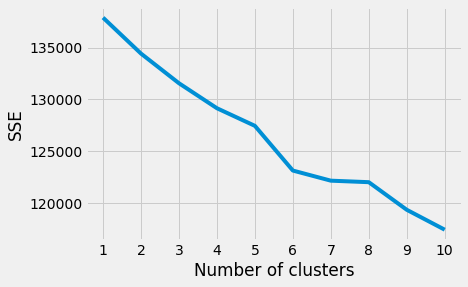

In [10]:
plt.style.use("fivethirtyeight")
plt.plot(range(1,11), sse)
plt.xticks(range(1,11))
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()

In [34]:
denselist = vectors.todense().tolist()

In [35]:
all_keywords = []
for final in denselist:
    x=0
    keywords = []
    for word in final:
        if word > 0:
            keywords.append(feature_names[x])
        x=x+1
    all_keywords.append(keywords)

In [36]:
model = KMeans(n_clusters= 6, init="random", max_iter=100, n_init=1)

model.fit(vectors)

order_centroids = model.cluster_centers_.argsort()[:, ::-1]

terms = vectorizer.get_feature_names_out()

In [37]:
i = 0
for cluster in order_centroids:
    print (f"Cluster {i}")
    for keyword in cluster[0:15]:
        print (terms[keyword])
    print ("")
    i=i+1

Cluster 0
people
going
president
world
make
work
new
time
states
united
country
american
years
today
right

Cluster 1
america
young
home
future
going
good
got
government
great
hard
health
help
history
important
folks

Cluster 2
know
young
history
forward
future
going
good
got
government
great
hard
health
help
home
years

Cluster 3
jobs
young
history
forward
future
going
good
got
government
great
hard
health
help
home
years

Cluster 4
think
young
help
forward
future
going
good
got
government
great
hard
health
history
families
home

Cluster 5
want
young
history
forward
future
going
good
got
government
great
hard
health
help
home
families



In [38]:
word_cloud_df = pd.DataFrame(denselist, columns = feature_names).T.sum(axis = 1)
word_cloud_df[:20]

able           877.0
america       2876.0
american      2208.0
americans     1711.0
believe       1116.0
best           710.0
better        1135.0
businesses     709.0
care          1320.0
change        1071.0
children       902.0
come          1328.0
community      745.0
congress      1012.0
continue       946.0
countries     1192.0
country       2278.0
day           1016.0
economic       679.0
economy       1215.0
dtype: float64

In [39]:
Cloud = WordCloud(background_color="white", max_words=30).generate_from_frequencies(word_cloud_df)
Cloud

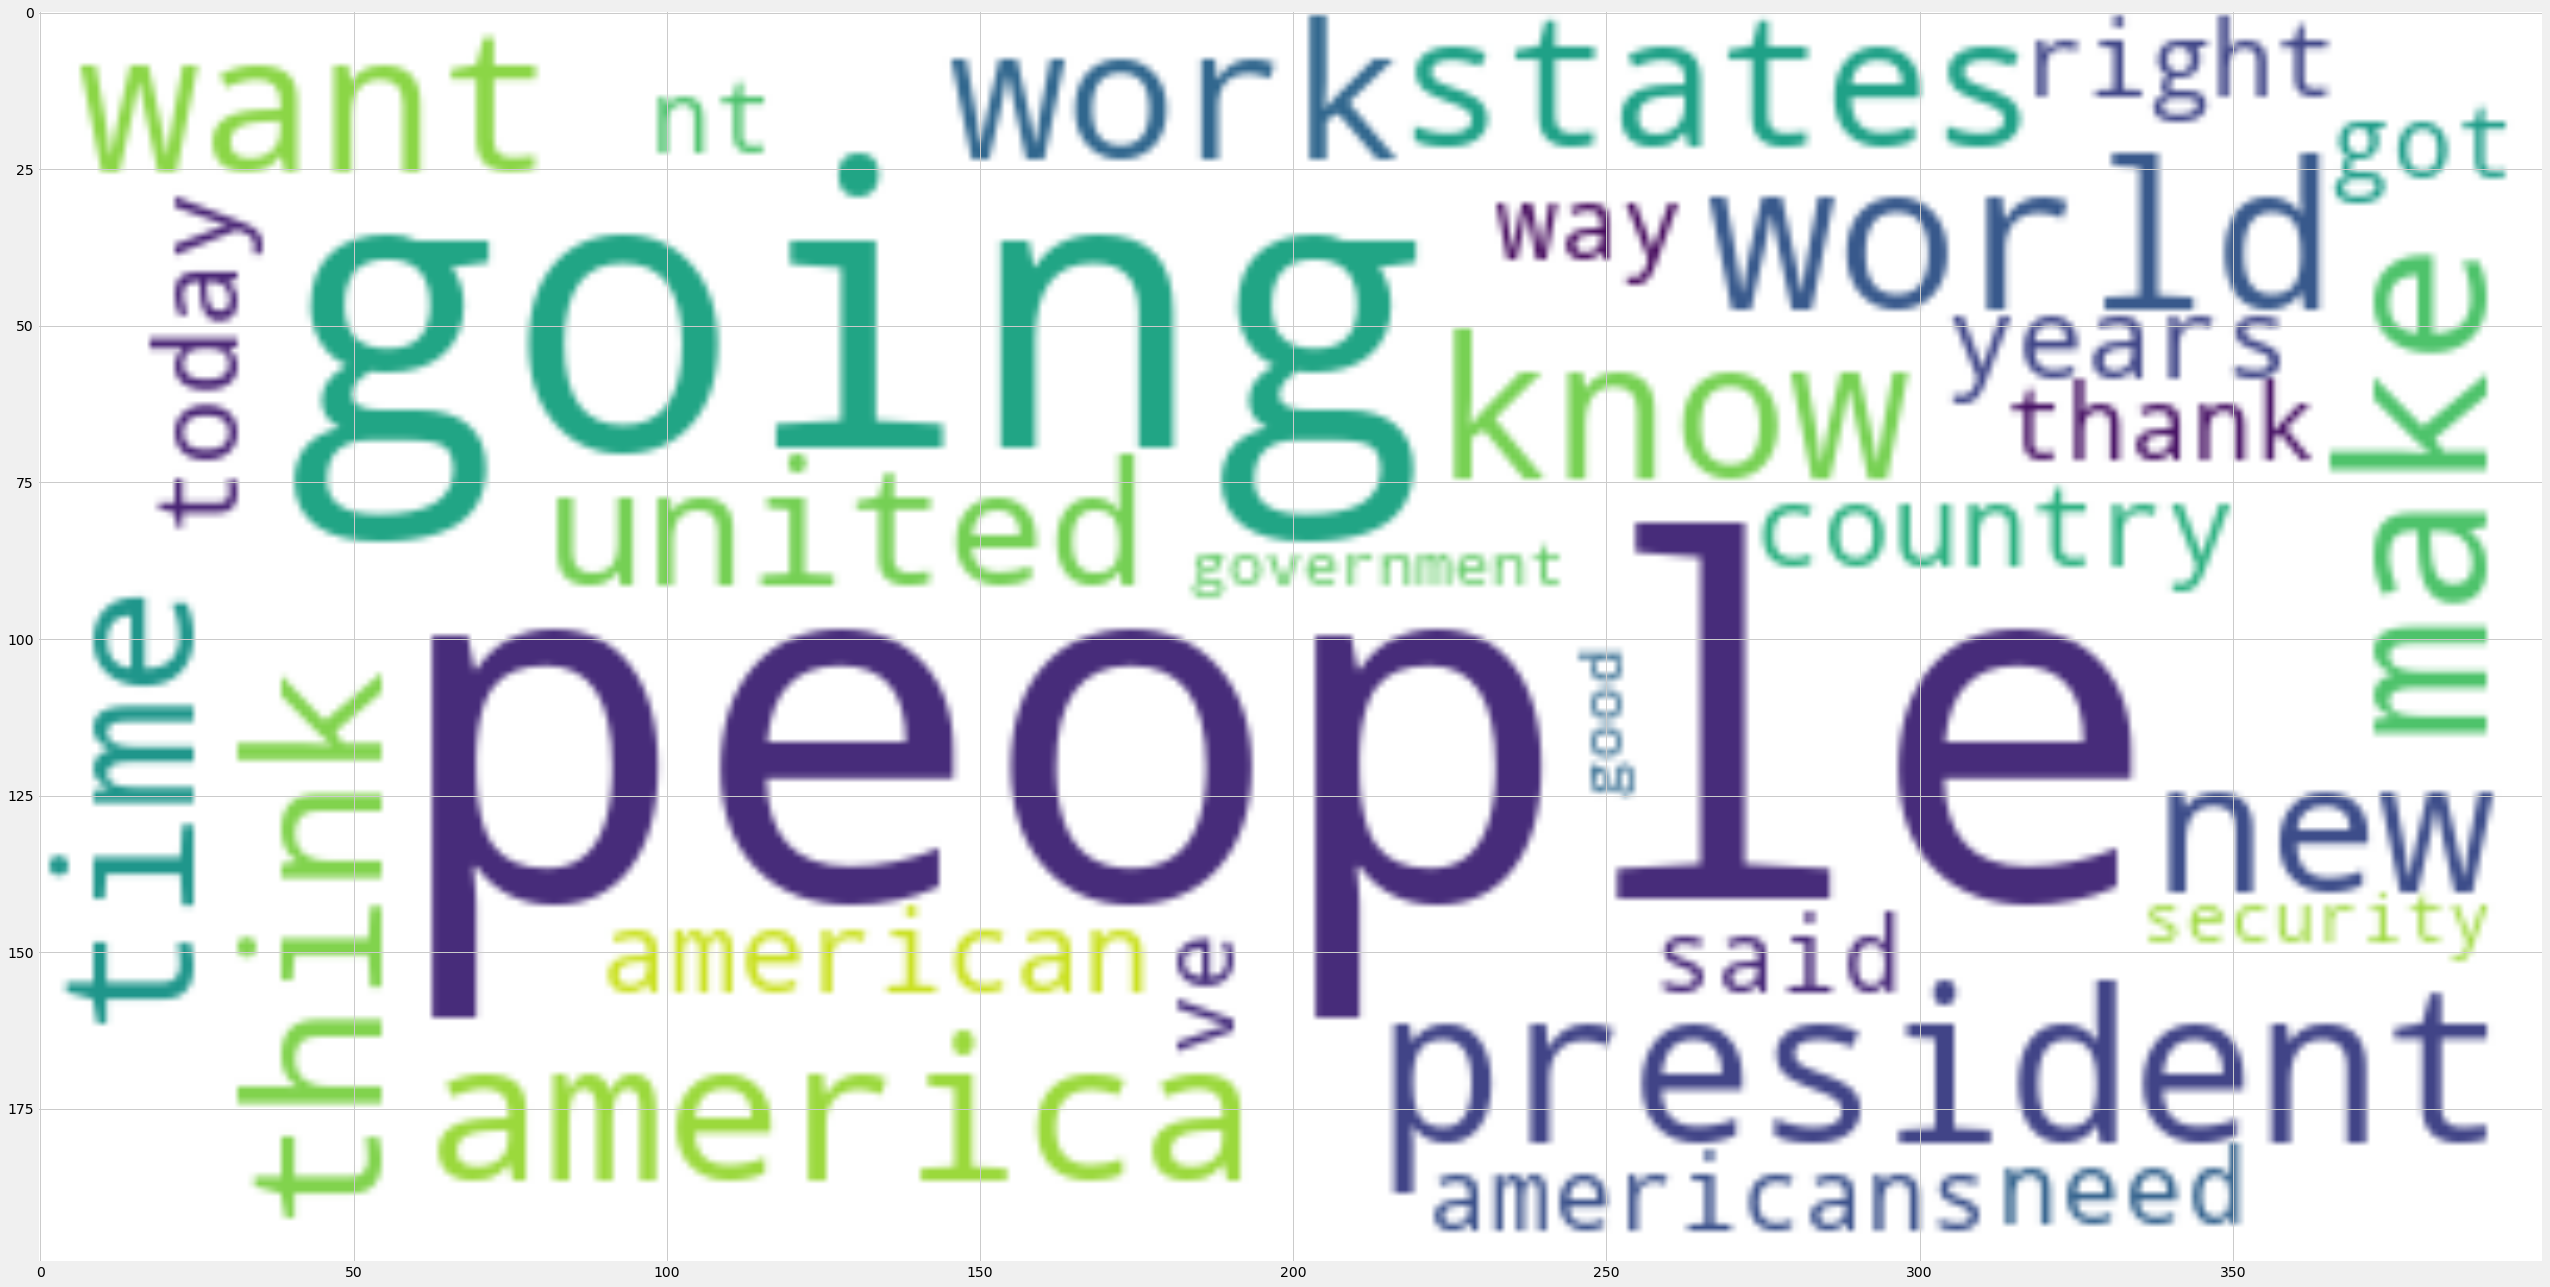

In [40]:
plt.figure(figsize=(40, 30))
plt.imshow(Cloud, interpolation='bilinear')
plt.show()